# Week 2: Supervised Techniques for Regression
## Boston Housing Assignment

 Scikit Learn documentation for this assignment:
 http://scikit-learn.org/stable/modules/model_evaluation.html 
 http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
 http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
 http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
 http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
 http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
 http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
 http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

 
 Textbook reference materials:
 Geron, A. 2017. Hands-On Machine Learning with Scikit-Learn
 and TensorFlow. Sebastopal, Calif.: O'Reilly. Chapter 3 Training Models
 has sections covering linear regression, polynomial regression,
 and regularized linear models. Sample code from the book is 
 available on GitHub at https://github.com/ageron/handson-ml


## Requirements for this assignment

    1) Use all explanatory variables (with the exception of neighborhood) and all 506 census tract observations from the Boston Housing Study.
    2) Use one of two response variables: (1) the median value of homes in thousands of 1970 dollars or (2) the log median value of homes in thousands of 1970 dollars. 
    3) Employ at least two regression modeling methods selected from those discussed in Chapter 4 of the Géron (2017) textbook: linear regression, ridge regression, lasso regression, and elastic net.
    4) Evaluate these methods within a cross-validation design, using root mean-squared error (RMSE) as an index of prediction error. 


Python scikit-learn should be your primary environment for conducting this research. Note that it is not necessary to employ polynomial regression in this assignment.

## Management problem:

Imagine that you are advising a real estate brokerage firm in its attempt to employ machine learning methods. The firm wants to use machine learning to complement conventional methods for assessing the market value of residential real estate. Of the modeling methods examined in your study, which would you recommend to management, and why?

# Discussion

After getting our data and libraries loaded in section A. Section B is dedicated to performing some exploratory data analysis. Some of data are transformed here to adjust the shape of the values relative to our dependant variable (log_MV). There were a few things I was aiming to do with this assignment the first was to evaluate the. The first was to imagine myself as a scientist with tranditional statistical approaches; EDA followed by selecting the most significant features, and contrast that to a modern machine learning route where the more impactful features are identified. The second was to evaluate the statistics generated by a few different methodologis (linear regression versus ElasticNet and linear regression versus lasso).

As for the first objective a subset of the columns were selected via exploratory analysis. Linear regression and elastic net are evaluated on the subset data. It is evident from the results below that these two methodologies produce very similar results in terms of coefficient estimates and term significance. To contrast this historical approach, lasso regression was employed to identify the features which were most impactful. After the important features were identified, linear regression was used to contrast the results obtained from the lasso methodology. Again the results obtained were very similar interms of coefficients, error, and feature significance. Likewise as an additonal example a linear regression of all availble terms was conducted demonstrating the presence of overfitting of the model evidenced by the low significance of a number of terms. 

Within each regression section the following generally applies:
    The train and test data are split from the data of interest
    The model is fit on the training set using a pipeline
    Predictions are made on the traning set and a parity plot is generated of predictions vs observed values
    The training set is then passed to cross validation and RMSE is reported of each fold along with the average of all folds
    Addiitonal Summary statistics for the coefficients and overal model are generated - Training Statistics
    The model for the test set is fit using the same pipeline employed for the training set
    Predictions are made on the test set and a parity plot is generated of predictions vs observed values
    Addiitonal summary statistics for the coefficients and overal model are generated - Test Statistics



# A: Libraries and data read-in

In [1]:
RANDOM_SEED = 42

# although we standardize X and y variables on input,
# we will fit the intercept term in the models
# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
from math import sqrt  # for root mean-squared error calculation

#diplay and plotting
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

#import from SKlearn
import sklearn.linear_model 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score  
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline

from scipy import stats

# read data for the Boston Housing Study
boston_input = pd.read_csv("C:/Users/bblank/Documents/Northwestern MSDS/datasets/boston.csv")

### Functions to yield information about the models

In [2]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
   # mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
   # print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

 
#This function print's statistics in a nice table format for linear regression
#requires the use of dataframe as inputs for all except the coefs arg.
def model_statistics(x_actual, y_actual, y_predict, coefs):

    matX = pd.DataFrame({"Constant":np.ones(len(x_actual))}).join(pd.DataFrame(x_actual.reset_index(drop=True)))
    MSE = (sum((y_actual-y_predict)**2))/(len(matX)-len(matX.columns))
    

    var_b = MSE*(np.linalg.inv(np.dot(matX.T,matX)).diagonal())
    
    sd_b = np.sqrt(var_b)
    ts_b = coefs/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(matX)-len(matX.columns)-1))) for i in ts_b]
    

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    coefs = np.round(coefs,4)

    SummaryDF = pd.DataFrame()
    SummaryDF["Coefficients"],SummaryDF["Standard Errors"],SummaryDF["t values"],SummaryDF["Probabilities"] = [coefs,sd_b,ts_b,p_values]

    return(SummaryDF)

# This is a function which returns the fomula of the model with it's coefficients
def pretty_print_coefs(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
        lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name) 
        for coef, name in lst)


# B: Descriptive Stats and Dataframe inspect

In [3]:
# check the pandas DataFrame object boston_input
print('\nboston DataFrame (first and last five rows):')
display(boston_input.head())
display(boston_input.tail())

print('\n\nGeneral description of the boston_input DataFrame:\n')
display(boston_input.info())

# drop neighborhood from the data being considered
boston = boston_input.drop('neighborhood', 1)
print('\n\nGeneral description of the boston DataFrame:\n')

display(boston.info())

print('\nDescriptive statistics of the boston DataFrame:\n')
display(boston.describe())


boston DataFrame (first and last five rows):


,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,Nahant,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,Swampscott,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,Swanpscott,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,Marblehead,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,Marblehead,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
501,Winthrop,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,Winthrop,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,Winthrop,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,Winthrop,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0
505,Winthrop,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273,21.0,7.88,19.0




General description of the boston_input DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   neighborhood  506 non-null    object 
 1   crim          506 non-null    float64
 2   zn            506 non-null    float64
 3   indus         506 non-null    float64
 4   chas          506 non-null    int64  
 5   nox           506 non-null    float64
 6   rooms         506 non-null    float64
 7   age           506 non-null    float64
 8   dis           506 non-null    float64
 9   rad           506 non-null    int64  
 10  tax           506 non-null    int64  
 11  ptratio       506 non-null    float64
 12  lstat         506 non-null    float64
 13  mv            506 non-null    float64
dtypes: float64(10), int64(3), object(1)
memory usage: 55.5+ KB


None



General description of the boston DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rooms    506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  mv       506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


None


Descriptive statistics of the boston DataFrame:



,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.528854
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.182176
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


array([[<AxesSubplot:title={'center':'crim'}>,
        <AxesSubplot:title={'center':'zn'}>,
        <AxesSubplot:title={'center':'indus'}>,
        <AxesSubplot:title={'center':'chas'}>],
       [<AxesSubplot:title={'center':'nox'}>,
        <AxesSubplot:title={'center':'rooms'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'dis'}>],
       [<AxesSubplot:title={'center':'rad'}>,
        <AxesSubplot:title={'center':'tax'}>,
        <AxesSubplot:title={'center':'ptratio'}>,
        <AxesSubplot:title={'center':'lstat'}>],
       [<AxesSubplot:title={'center':'mv'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

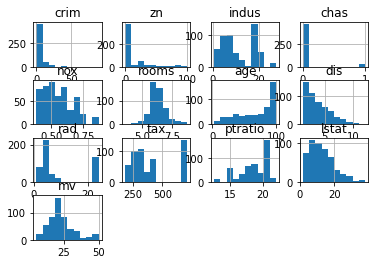

In [4]:
boston.hist()

## Correlation Heatmap

Text(0.5, 0.98, 'Correlation Heatmap for Boston')

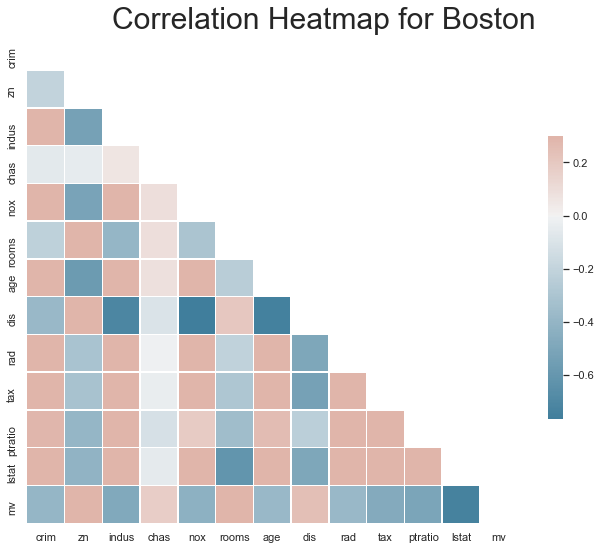

In [5]:
sns.set_theme(style="white")

#correlation matrix
corr =boston.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.subplots_adjust(top=1)
plt.suptitle("Correlation Heatmap for Boston",fontsize= 30)


<AxesSubplot:xlabel='ptratio', ylabel='tax'>

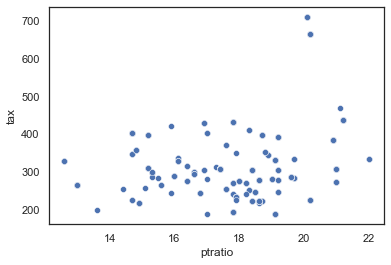

In [6]:
sns.scatterplot(boston.ptratio, boston.tax)

<AxesSubplot:xlabel='tax', ylabel='mv'>

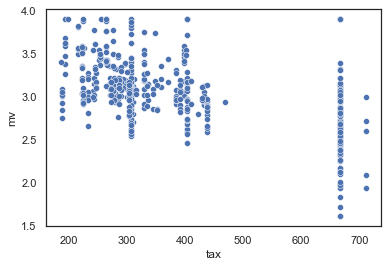

In [7]:
sns.scatterplot(boston.tax, np.log(boston.mv))


<AxesSubplot:>

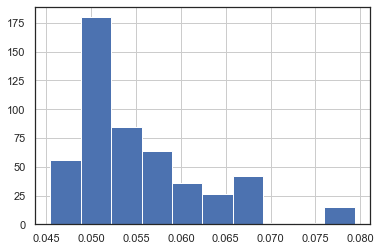

In [8]:
inv_ratio= 1/boston.ptratio
inv_ratio.hist()


<AxesSubplot:>

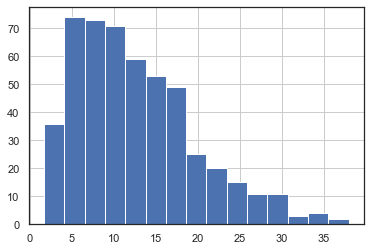

In [9]:
boston.lstat.hist(bins=15)

<AxesSubplot:>

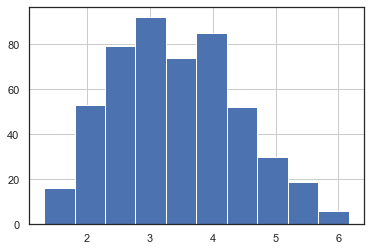

In [10]:
log = np.sqrt(boston.lstat)

log.hist()



<AxesSubplot:>

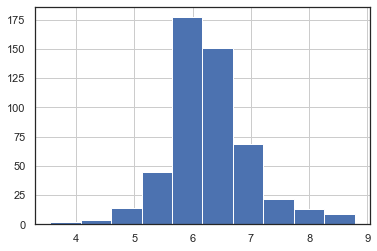

In [11]:
boston.rooms.hist()

<AxesSubplot:>

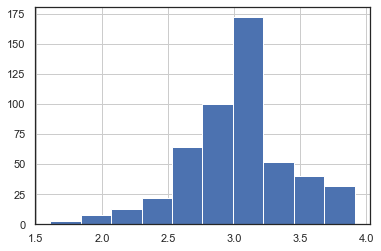

In [12]:
np.log(boston.mv).hist()

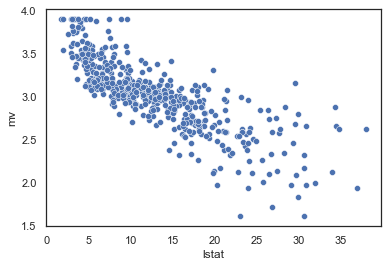

In [13]:
logplot = sns.scatterplot(y=np.log(boston.mv), x=boston.lstat)



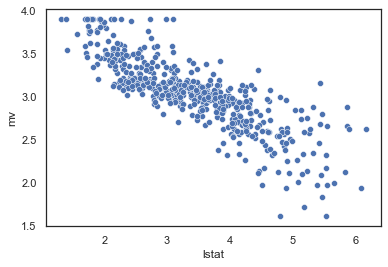

In [14]:
sqrtfeatureplot = sns.scatterplot(y=np.log(boston.mv), x= np.sqrt(boston.lstat))

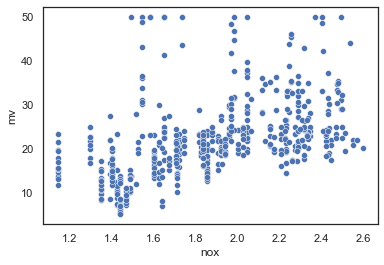

In [15]:
sqrtfeatureplot = sns.scatterplot(y=boston.mv, x= 1/boston.nox)


# C: Scientist's approach; select correlated features
## C1.) Data Preparation

In [16]:
boston_trimmed = boston[['mv', 'nox', 'lstat', 'ptratio', 'rooms', 'tax']]

boston_trimmed['sqrt_lstat'] = np.sqrt(boston_trimmed['lstat'])
boston_trimmed['log_MV']= np.log(boston_trimmed['mv'])

boston_trimmed.drop(['lstat', 'mv'], axis=1, inplace=True)


Text(0.5, 0.98, 'Correlation Heatmap for Boston_trimmed')

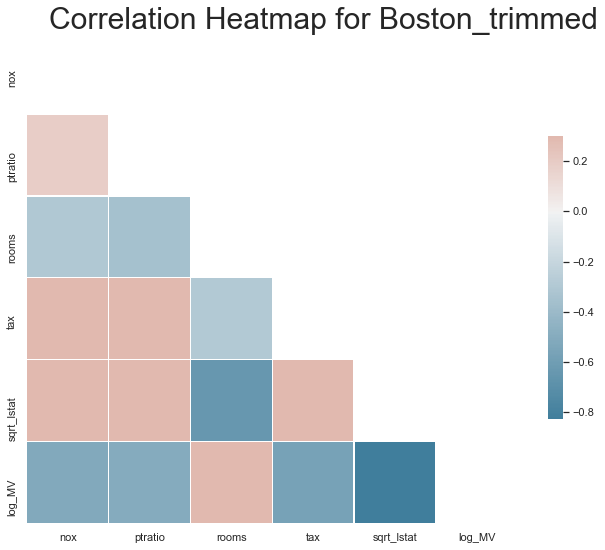

In [17]:
sns.set_theme(style="white")

#correlation matrix
corr =boston_trimmed.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.subplots_adjust(top=1)
plt.suptitle("Correlation Heatmap for Boston_trimmed",fontsize= 30)

### Here the scientist selects features sqrt_lstat, tax

In [18]:
# here is the data used in the non scaled models
model_data =boston_trimmed[['log_MV','sqrt_lstat', 'tax']]

In [19]:
Trimmed_Train, Trimmed_Test = train_test_split(model_data, test_size = 0.2, random_state = RANDOM_SEED)

#separate features from labels

T_Test_y = Trimmed_Test['log_MV'].copy()
T_Test_X = Trimmed_Test.drop('log_MV', axis=1)

T_Train_y = Trimmed_Train['log_MV'].copy()
T_Train_X = Trimmed_Train.drop('log_MV', axis=1)




## C2.) Linear Regression of selected features

In [20]:
Linear_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
        ])

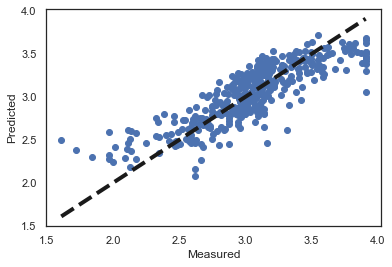

In [21]:
Linear_pipe.fit(T_Train_X, T_Train_y)

Linear_T_train_pred = Linear_pipe.predict(T_Train_X)


fig, T_train = plt.subplots()
T_train.scatter(T_Train_y, Linear_T_train_pred)
#plt.plot(Train_Features, Train_Labels_pred, color='blue', linewidth=3)
T_train.plot([T_Train_y.min(), T_Train_y.max()], [T_Train_y.min(), T_Train_y.max()], 'k--', lw=4)
T_train.set_xlabel('Measured')
T_train.set_ylabel('Predicted')

plt.show()


### Model Summary Stats (Linear Train)

In [22]:
regression_results(T_Train_y, Linear_T_train_pred)

linear_coefs = np.append(Linear_pipe.named_steps['regressor'].intercept_, Linear_pipe.named_steps['regressor'].coef_)
model_statistics(x_actual=T_Train_X, y_actual=T_Train_y, y_predict=Linear_T_train_pred, coefs=linear_coefs)

explained_variance:  0.7054
r2:  0.7054
MAE:  0.1741
MSE:  0.0495
RMSE:  0.2225


,Coefficients,Standard Errors,t values,Probabilities
0,3.0458,0.041,74.988,0.0
1,-0.3028,0.013,-22.750,0.0
2,-0.0690,0.000,-874.124,0.0


### CrossValidation

In [23]:
kfold = KFold(n_splits=8, random_state=RANDOM_SEED)

#get RMSE for the folds
cv_results = np.sqrt(-cross_val_score(Linear_pipe, T_Train_X, T_Train_y, cv=kfold, scoring= 'neg_mean_squared_error'))
print(cv_results)
np.mean(cv_results)

[0.25034314 0.25496817 0.20509183 0.19883053 0.22530105 0.2082803
 0.21951567 0.22369598]


0.22325333411448645

### Evaluate on Test

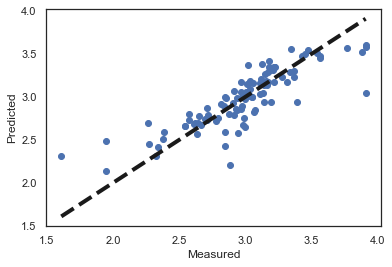

In [24]:
Linear_pipe.fit(T_Test_X, T_Test_y)

Linear_T_test_pred =Linear_pipe.predict(T_Test_X)

fig, Linear_test = plt.subplots()
Linear_test.scatter(T_Test_y, Linear_T_test_pred)
#plt.plot(Train_Features, Train_Labels_pred, color='blue', linewidth=3)
Linear_test.plot([T_Train_y.min(), T_Train_y.max()], [T_Train_y.min(), T_Train_y.max()], 'k--', lw=4)
Linear_test.set_xlabel('Measured')
Linear_test.set_ylabel('Predicted')

plt.show()


### Model Summary Stats (Linear Test)

In [25]:
regression_results(T_Test_y, Linear_T_test_pred)

linear_coefs = np.append(Linear_pipe.named_steps['regressor'].intercept_, Linear_pipe.named_steps['regressor'].coef_)
model_statistics(x_actual=T_Test_X, y_actual=T_Test_y, y_predict=Linear_T_test_pred, coefs=linear_coefs)

explained_variance:  0.7063
r2:  0.7063
MAE:  0.1531
MSE:  0.0461
RMSE:  0.2147


,Coefficients,Standard Errors,t values,Probabilities
0,2.9900,0.081,37.025,0.0
1,-0.2961,0.027,-10.858,0.0
2,-0.0567,0.000,-373.176,0.0


## C3.) Scientist Approach ElasticNet Regression

In [26]:
Elastic_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', ElasticNet(alpha=0.005, l1_ratio= 0.5))
        ])

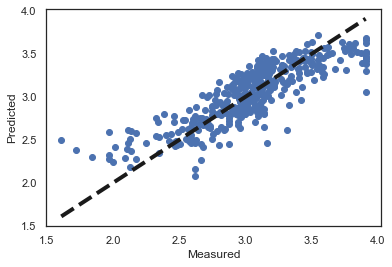

In [27]:
Elastic_pipe.fit(T_Train_X, T_Train_y)

Elastic_T_train_pred = Elastic_pipe.predict(T_Train_X)

fig, Elastic_train = plt.subplots()
Elastic_train.scatter(T_Train_y, Linear_T_train_pred)
#plt.plot(Train_Features, Train_Labels_pred, color='blue', linewidth=3)
Elastic_train.plot([T_Train_y.min(), T_Train_y.max()], [T_Train_y.min(), T_Train_y.max()], 'k--', lw=4)
Elastic_train.set_xlabel('Measured')
Elastic_train.set_ylabel('Predicted')

plt.show()

### ElasticNet Model Summary Stats (Train)

In [28]:
regression_results(T_Train_y, Elastic_T_train_pred)

EN_coefs = np.append(Elastic_pipe.named_steps['regressor'].intercept_, Elastic_pipe.named_steps['regressor'].coef_)
model_statistics(x_actual=T_Train_X, y_actual=T_Train_y, y_predict=Elastic_T_train_pred, coefs=EN_coefs)

explained_variance:  0.7054
r2:  0.7054
MAE:  0.1739
MSE:  0.0495
RMSE:  0.2226


,Coefficients,Standard Errors,t values,Probabilities
0,3.0458,0.041,74.980,0.0
1,-0.3002,0.013,-22.556,0.0
2,-0.0677,0.000,-857.332,0.0


### Cross validation ElasticNet (Train)

In [29]:
cv_results = np.sqrt(-cross_val_score(Elastic_pipe, T_Train_X, T_Train_y, cv=kfold, scoring= 'neg_mean_squared_error'))
print(cv_results)
np.mean(cv_results)

[0.24982951 0.25487111 0.20565915 0.19961777 0.22542801 0.20846322
 0.2198552  0.22271523]


0.22330489839645462

### Evaluate on Test

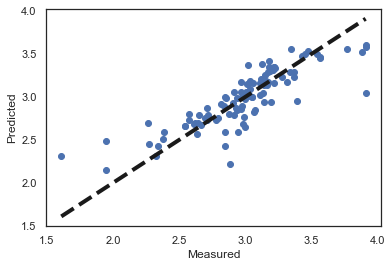

In [30]:
Elastic_pipe.fit(T_Test_X, T_Test_y)

Elastic_T_test_pred = Elastic_pipe.predict(T_Test_X)

fig, Elastic_test = plt.subplots()
Elastic_test.scatter(T_Test_y, Elastic_T_test_pred)
#plt.plot(Train_Features, Train_Labels_pred, color='blue', linewidth=3)
Elastic_test.plot([T_Train_y.min(), T_Train_y.max()], [T_Train_y.min(), T_Train_y.max()], 'k--', lw=4)
Elastic_test.set_xlabel('Measured')
Elastic_test.set_ylabel('Predicted')

plt.show()



### ElasticNet model summary statistics (Test)

In [31]:
regression_results(T_Test_y, Elastic_T_test_pred)

EN_coefs = np.append(Elastic_pipe.named_steps['regressor'].intercept_, Elastic_pipe.named_steps['regressor'].coef_)
model_statistics(x_actual=T_Test_X, y_actual=T_Test_y, y_predict=Elastic_T_test_pred, coefs=EN_coefs)


explained_variance:  0.7062
r2:  0.7062
MAE:  0.1531
MSE:  0.0461
RMSE:  0.2147


,Coefficients,Standard Errors,t values,Probabilities
0,2.9900,0.081,37.020,0.0
1,-0.2935,0.027,-10.762,0.0
2,-0.0555,0.000,-365.788,0.0


# D. Machine Learning Approach
## D1.) Data Prep

In [32]:
#get our data back in order
boston_new =boston.copy()
#boston_new['inv_nox'] = 1/boston_new['nox']
boston_new['sqrt_lstat'] = np.sqrt(boston_new['lstat'])
#boston_new['inv_ptratio'] = 1/boston_new['ptratio']
boston_new['log_MV']= np.log(boston_new['mv'])

boston_new.drop(['lstat', 'mv'], axis=1, inplace=True)



In [33]:
#cols = boston_new.columns

Train, Test = train_test_split(boston_new, test_size = 0.2, random_state = RANDOM_SEED)

#separate features from labels for test
init_Test_Labels = Test['log_MV'].copy()
init_Test_Features = Test.drop('log_MV', axis=1)

#separate features from labels for train
init_y = Train['log_MV'].copy()
init_X = Train.drop('log_MV', axis=1)


## D2.) Lasso Regression on Train

In [80]:
#Ridge Regression pipeline

lasso_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Lasso(alpha=0.03))
        ])

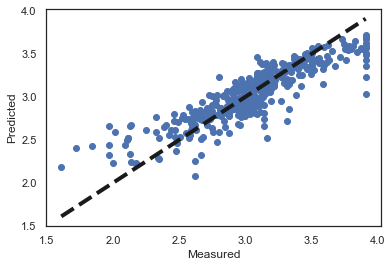

In [81]:

lasso_pipe.fit(init_X, init_y)
lasso_Xtrain_pred =lasso_pipe.predict(init_X)

fig, Lasso_train = plt.subplots()
Lasso_train.scatter(init_y, lasso_Xtrain_pred)
#plt.plot(Train_Features, Train_Labels_pred, color='blue', linewidth=3)
Lasso_train.plot([init_y.min(), init_y.max()], [init_y.min(), init_y.max()], 'k--', lw=4)
Lasso_train.set_xlabel('Measured')
Lasso_train.set_ylabel('Predicted')

plt.show()


#lasso_pipe.named_steps['regressor'].coef_



### Lasso Training Model Statistics

In [82]:

regression_results(init_y, lasso_Xtrain_pred)


lasso_coefs = np.append(lasso_pipe.named_steps['regressor'].intercept_, lasso_pipe.named_steps['regressor'].coef_)
model_statistics(x_actual=init_X, y_actual=init_y, y_predict=lasso_Xtrain_pred, coefs=lasso_coefs)

explained_variance:  0.7598
r2:  0.7598
MAE:  0.1498
MSE:  0.0404
RMSE:  0.2009


,Coefficients,Standard Errors,t values,Probabilities
0,3.0458,0.247,12.354,0.000
1,-0.0607,0.001,-40.718,0.000
2,-0.0000,0.001,-0.000,1.000
3,-0.0000,0.003,-0.000,1.000
4,0.0053,0.041,0.128,0.898
5,-0.0000,0.183,-0.000,1.000
6,0.0582,0.021,2.815,0.005
7,0.0000,0.001,0.000,1.000
8,-0.0000,0.010,-0.000,1.000
9,-0.0000,0.003,-0.000,1.000


### Lasso impactful features
    most impactful features (in descending order) are: sqrt_lstat, crim, rooms, ptratio, tax & chase (these last two are really small

In [83]:
print ("Lasso model:", pretty_print_coefs(lasso_pipe.named_steps['regressor'].coef_))


Lasso model: -0.061 * X0 + -0.0 * X1 + -0.0 * X2 + 0.005 * X3 + -0.0 * X4 + 0.058 * X5 + 0.0 * X6 + -0.0 * X7 + -0.0 * X8 + -0.01 * X9 + -0.041 * X10 + -0.226 * X11


In [84]:
init_X.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rooms', 'age', 'dis', 'rad',
       'tax', 'ptratio', 'sqrt_lstat'],
      dtype='object')

### Lasso evaluation on test data

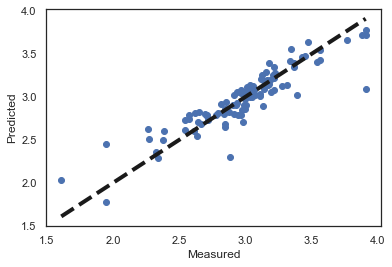

In [39]:
lasso_pipe.fit(init_Test_Features, init_Test_Labels)

Lasso_test_pred = lasso_pipe.predict(init_Test_Features)

fig, Lasso_test = plt.subplots()
Lasso_test.scatter(init_Test_Labels, Lasso_test_pred)
#plt.plot(Train_Features, Train_Labels_pred, color='blue', linewidth=3)
Lasso_test.plot([init_Test_Labels.min(), init_Test_Labels.max()], [init_Test_Labels.min(), init_Test_Labels.max()], 'k--', lw=4)
Lasso_test.set_xlabel('Measured')
Lasso_test.set_ylabel('Predicted')

plt.show()


### Lasso Model Statistics (test)

In [40]:
lasso_Test_pred = lasso_pipe.predict(init_Test_Features)
regression_results(init_Test_Labels, lasso_Test_pred)

lasso_coefs = np.append(lasso_pipe.named_steps['regressor'].intercept_, lasso_pipe.named_steps['regressor'].coef_)
model_statistics(x_actual=init_Test_Features, y_actual=init_Test_Labels, y_predict=lasso_Test_pred, coefs=lasso_coefs)

explained_variance:  0.8165
r2:  0.8165
MAE:  0.1165
MSE:  0.0288
RMSE:  0.1697


,Coefficients,Standard Errors,t values,Probabilities
0,2.9900,0.461,6.485,0.000
1,-0.1075,0.004,-27.241,0.000
2,0.0349,0.001,31.508,0.000
3,-0.0000,0.006,-0.000,1.000
4,0.0230,0.084,0.275,0.784
5,-0.0871,0.373,-0.233,0.816
6,0.0057,0.038,0.150,0.881
7,0.0246,0.001,17.650,0.000
8,-0.0714,0.018,-4.070,0.000
9,0.1438,0.006,25.475,0.000


# 2. LinearRegression

## 2a.) Linear Regression on Train (all features)

In [53]:
Linear_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
        ])

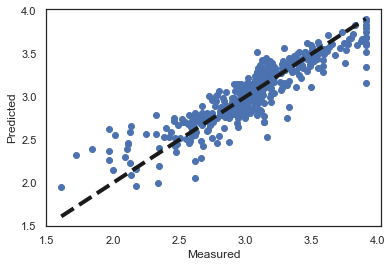

In [54]:
Linear_pipe.fit(init_X, init_y)

Linear_Xsub_train_pred =Linear_pipe.predict(init_X)

fig, Lin_train = plt.subplots()
Lin_train.scatter(init_y, Linear_Xsub_train_pred)
#plt.plot(Train_Features, Train_Labels_pred, color='blue', linewidth=3)
Lin_train.plot([init_y.min(), init_y.max()], [init_y.min(), init_y.max()], 'k--', lw=4)
Lin_train.set_xlabel('Measured')
Lin_train.set_ylabel('Predicted')

plt.show()

In [55]:
regression_results(init_y, Linear_Xsub_train_pred)

sub_coefs = np.append(Linear_pipe.named_steps['regressor'].intercept_, Linear_pipe.named_steps['regressor'].coef_)

model_statistics(x_actual= init_X, y_actual= init_y, y_predict=Linear_Xsub_train_pred, coefs=sub_coefs)

explained_variance:  0.8033
r2:  0.8033
MAE:  0.1356
MSE:  0.0331
RMSE:  0.1818


,Coefficients,Standard Errors,t values,Probabilities
0,3.0458,0.223,13.652,0.000
1,-0.0938,0.001,-69.545,0.000
2,0.0127,0.001,20.427,0.000
3,0.0151,0.003,5.770,0.000
4,0.0248,0.037,0.666,0.506
5,-0.0849,0.165,-0.514,0.608
6,0.0529,0.019,2.825,0.005
7,0.0122,0.001,21.211,0.000
8,-0.1018,0.009,-11.533,0.000
9,0.0859,0.003,29.021,0.000


### Linear Regression Statistics (all features)

In [56]:
regression_results(init_y, Linear_Xsub_train_pred)

sub_coefs = np.append(Linear_pipe.named_steps['regressor'].intercept_, Linear_pipe.named_steps['regressor'].coef_)

model_statistics(x_actual= init_X, y_actual= init_y, y_predict=Linear_Xsub_train_pred, coefs=sub_coefs)

explained_variance:  0.8033
r2:  0.8033
MAE:  0.1356
MSE:  0.0331
RMSE:  0.1818


,Coefficients,Standard Errors,t values,Probabilities
0,3.0458,0.223,13.652,0.000
1,-0.0938,0.001,-69.545,0.000
2,0.0127,0.001,20.427,0.000
3,0.0151,0.003,5.770,0.000
4,0.0248,0.037,0.666,0.506
5,-0.0849,0.165,-0.514,0.608
6,0.0529,0.019,2.825,0.005
7,0.0122,0.001,21.211,0.000
8,-0.1018,0.009,-11.533,0.000
9,0.0859,0.003,29.021,0.000


## From this we can see that R2 is higher (RMSE also lower) for linear regression. 
    1) However, there are insignificant terms in our model indicated by low t-stats and high p-values in the summary table above.
    2) The regularization of the lasso regressior penalizes the contribution of those coefficients such that it sets them to zero.
    
### Let's use the most prominant features from lasso regression (those with the largest coefficients) for our linear regression

## 2b.) Linear Regression with lasso downselected features

In [90]:
boston_subset = Train[['sqrt_lstat', 'crim' , 'rooms', 'ptratio', 'tax','log_MV']]
X_sub = boston_subset.iloc[:,0:5]
y_sub = boston_subset.iloc[:,-1]

X_sub.columns

Index(['sqrt_lstat', 'crim', 'rooms', 'ptratio', 'tax'], dtype='object')

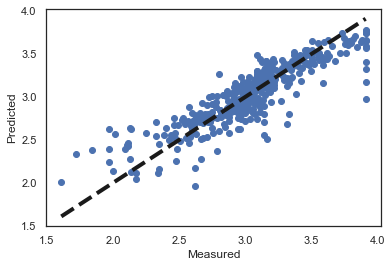

In [91]:
Linear_pipe.fit(X_sub, y_sub)

Linear_Xsub_train_pred =Linear_pipe.predict(X_sub)

fig, train = plt.subplots()
train.scatter(y_sub, Linear_Xsub_train_pred)
#plt.plot(Train_Features, Train_Labels_pred, color='blue', linewidth=3)
train.plot([y_sub.min(), y_sub.max()], [y_sub.min(), y_sub.max()], 'k--', lw=4)
train.set_xlabel('Measured')
train.set_ylabel('Predicted')

plt.show()

### Downselected Linear Regression model statistics

In [92]:
regression_results(y_sub,Linear_Xsub_train_pred)
sub_coefs = np.append(Linear_pipe.named_steps['regressor'].intercept_, Linear_pipe.named_steps['regressor'].coef_)
model_statistics(x_actual= X_sub, y_actual= y_sub, y_predict=Linear_Xsub_train_pred, coefs=sub_coefs)

explained_variance:  0.7686
r2:  0.7686
MAE:  0.1465
MSE:  0.0389
RMSE:  0.1972


,Coefficients,Standard Errors,t values,Probabilities
0,3.0458,0.182,16.730,0.0
1,-0.2272,0.015,-15.003,0.0
2,-0.0780,0.001,-56.515,0.0
3,0.0771,0.019,4.123,0.0
4,-0.0566,0.005,-11.016,0.0
5,-0.0173,0.000,-208.269,0.0


In [93]:
kfold = KFold(n_splits=8, random_state=RANDOM_SEED)

#get RMSE for the folds
cv_results = np.sqrt(-cross_val_score(Linear_pipe, X_sub, y_sub, cv=kfold, scoring= 'neg_mean_squared_error'))
print(cv_results)
np.mean(cv_results)

[0.20952891 0.21034187 0.1907632  0.20302689 0.23126345 0.18055653
 0.18793943 0.20878712]


0.20277592475036607

## implement on test

In [105]:
Test_subset = Test[['sqrt_lstat', 'crim' , 'rooms', 'ptratio', 'tax','log_MV']]
Test_X_sub = Test_subset.iloc[:,0:5]
Test_y_sub = Test_subset.iloc[:,-1]


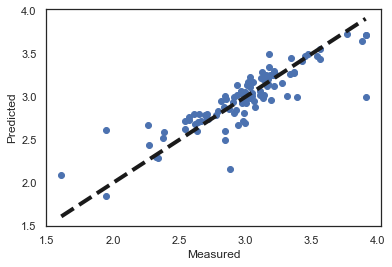

In [106]:
Linear_pipe.fit(Test_X_sub, Test_y_sub)

Linear_Xsub_test_pred =Linear_pipe.predict(Test_X_sub)

fig, Test_ln = plt.subplots()
Test_ln.scatter(Test_y_sub, Linear_Xsub_test_pred)
#plt.plot(Train_Features, Train_Labels_pred, color='blue', linewidth=3)
Test_ln.plot([Test_y_sub.min(), Test_y_sub.max()], [Test_y_sub.min(), Test_y_sub.max()], 'k--', lw=4)
Test_ln.set_xlabel('Measured')
Test_ln.set_ylabel('Predicted')

plt.show()

### Summary Statistis for downselected linear regression (test)

In [108]:
### Noregression_results(y_sub,Linear_Xsub_train_pred)
regression_results(Test_y_sub,Linear_Xsub_test_pred)
test_sub_coefs = np.append(Linear_pipe.named_steps['regressor'].intercept_, Linear_pipe.named_steps['regressor'].coef_)
model_statistics(x_actual= Test_X_sub, y_actual= Test_y_sub, y_predict=Linear_Xsub_test_pred, coefs=test_sub_coefs)

explained_variance:  0.7466
r2:  0.7466
MAE:  0.1363
MSE:  0.0397
RMSE:  0.1994


,Coefficients,Standard Errors,t values,Probabilities
0,2.9900,0.415,7.201,0.000
1,-0.2342,0.033,-7.041,0.000
2,-0.0730,0.004,-19.272,0.000
3,0.0311,0.040,0.774,0.441
4,-0.0705,0.014,-4.989,0.000
5,0.0003,0.000,1.454,0.149
